## PSE - Puya

In [2]:
#import pipeline as pipe
import pandas as pd
import numpy as np
import glob


#def load_data():
#    data = pipe.pipeline()


def load_preprocess_data():
    path = r'./Data-out' 
    all_files = glob.glob(path + "/hda_dataset_uniform_random_[0-7].csv")
    all_files.sort()
    
    #Load all data
    df = (pd.read_csv(f) for f in all_files)
    
    #Merge all the files with each other
    #Drop all duplicates
    concat_df = pd.concat(df).drop_duplicates().reset_index(drop=True)
    concat_df = concat_df.sort_values(by=['case', 'ts'])
    #reset index
    concat_df = concat_df.reset_index(drop=True)
    #Create a csv file
    #concat_df.to_csv('test1.csv')
    return concat_df

In [3]:
df = load_preprocess_data()
df.head()

,case,event,ts
0,1,Order imported,2018-09-02 00:02:30
1,1,Order checked,2018-09-02 00:02:41
2,1,Address correction,2018-09-02 00:06:21
3,1,Order creation failed (SYS-2),2018-09-02 00:07:00
4,1,Device hand-out,2018-09-03 16:36:00


### Brand-Analyse

In [76]:
brands = pd.read_csv('./Data-out/brands.csv', sep =",")
brands.head()

,pid,BRAND
0,66605,BRAND_0
1,66715,BRAND_0
2,66756,BRAND_0
3,66774,BRAND_0
4,66794,BRAND_0


In [77]:
print("Anzahl verschiedener Brands: {}".format(brands.BRAND.unique().size))

Anzahl verschiedener Brands: 10


In [80]:
group = brands.groupby(['BRAND']).count()
group['brand'] = group.index
group

,pid,brand
BRAND,,
BRAND_0,4715,BRAND_0
BRAND_1,205293,BRAND_1
BRAND_2,10544,BRAND_2
BRAND_3,193,BRAND_3
BRAND_4,1657,BRAND_4
BRAND_5,9,BRAND_5
BRAND_6,26359,BRAND_6
BRAND_7,14037,BRAND_7
BRAND_8,62,BRAND_8


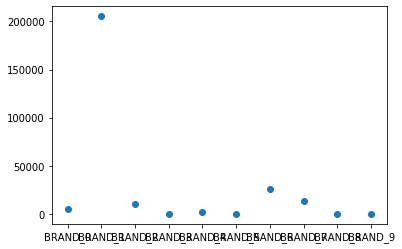

In [81]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(group['brand'], group['pid'])


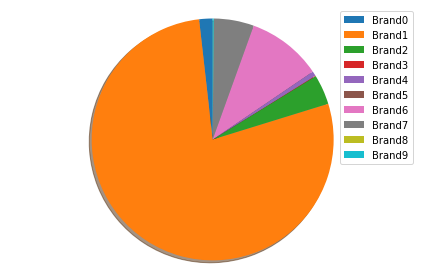

In [82]:
myArr = group['pid'].to_numpy()


# Pie chart, where the slices will be ordered and plotted counter-clockwise:
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
labels = ['Brand0', 'Brand1', 'Brand2', 'Brand3', 'Brand4', 'Brand5', 'Brand6', 'Brand7', 'Brand8', 'Brand9']
patches, texts = plt.pie(myArr, startangle=90, shadow=True)
#, autopct='%1.1f%%', pctdistance=0.7 , shadow=True
plt.legend(patches, labels, loc="best")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

In [83]:
df1 = df.join(brands.set_index('pid'), on='case')
df1[df1['BRAND'] == 'BRAND_7' ]

,case,event,ts,BRAND
709923,131476,Export from online shop,2018-10-19 16:18:34,BRAND_7
709924,131476,Order imported,2018-10-23 15:38:41,BRAND_7
709925,131476,Address correction,2018-10-23 15:40:36,BRAND_7
709926,131476,Order checked,2018-10-23 15:42:27,BRAND_7
709927,131476,Ready for payment processing,2018-10-23 15:42:27,BRAND_7
...,...,...,...,...
1405555,263239,Delivery approved,2018-12-01 23:48:20,BRAND_7
1405556,263239,In delivery,2018-12-01 23:48:24,BRAND_7
1405557,263239,Ready to deliver,2018-12-03 05:04:35,BRAND_7
1405558,263239,Delivered,2018-12-03 09:35:03,BRAND_7


### Zusammenhang zwischen Lieferzeit und Retoure

In [49]:
delivery_data = df[(df['event'] == "In delivery")]
cancel_data = df[(df['event'] == "Cancellation requested")]

dc_data = pd.merge(delivery_data, cancel_data, on="case", how="inner")
dc_data = dc_data[['case', 'event_x', 'event_y', 'ts_x', 'ts_y']]
dc_data['diff'] = pd.to_datetime(dc_data['ts_y']) - pd.to_datetime(dc_data['ts_x'])
dc_data['diff'] = dc_data['diff']/np.timedelta64(1, 'D')
dc_data = dc_data.sort_values(by=['diff'], ascending=False)
dc_data

,case,event_x,event_y,ts_x,ts_y,diff
196,174218,In delivery,Cancellation requested,2018-11-04 12:25:19,2018-11-28 09:21:34,23.872396
41,98986,In delivery,Cancellation requested,2018-10-16 04:15:14,2018-11-06 12:33:07,21.345752
32,87081,In delivery,Cancellation requested,2018-10-17 12:06:58,2018-11-07 15:31:47,21.142234
28,80406,In delivery,Cancellation requested,2018-10-16 11:04:41,2018-11-05 15:41:54,20.192512
29,84210,In delivery,Cancellation requested,2018-10-12 10:18:48,2018-10-30 08:53:27,17.940729
...,...,...,...,...,...,...
198,243941,In delivery,Cancellation requested,2018-11-27 11:30:28,2018-11-27 11:31:00,0.000370
1,58058,In delivery,Cancellation requested,2018-10-02 08:09:49,2018-10-02 08:10:20,0.000359
37,90322,In delivery,Cancellation requested,2018-10-13 12:32:15,2018-10-13 12:32:41,0.000301
194,171849,In delivery,Cancellation requested,2018-11-03 11:19:28,2018-11-03 11:19:54,0.000301


In [55]:
delivery_data = df[(df['event'] == "Order checked")]
cancel_data = df[(df['event'] == "Return delivery initiated")]

dc_data = pd.merge(delivery_data, cancel_data, on="case", how="inner")
dc_data = dc_data[['case', 'event_x', 'event_y', 'ts_x', 'ts_y']]
dc_data['diff'] = pd.to_datetime(dc_data['ts_y']) - pd.to_datetime(dc_data['ts_x'])
dc_data['diff'] = dc_data['diff']/np.timedelta64(1, 'D')
dc_data = dc_data.sort_values(by=['diff'], ascending=False)
dc_data

,case,event_x,event_y,ts_x,ts_y,diff
43,616,Order checked,Return delivery initiated,2018-09-02 17:17:40,2018-11-14 14:46:25,72.894965
1108,15088,Order checked,Return delivery initiated,2018-09-10 16:23:32,2018-11-19 12:31:02,69.838542
615,8548,Order checked,Return delivery initiated,2018-09-11 08:24:16,2018-11-19 12:16:02,69.160949
1337,18604,Order checked,Return delivery initiated,2018-09-11 22:47:48,2018-11-19 11:46:21,68.540660
4022,56717,Order checked,Return delivery initiated,2018-10-01 16:37:57,2018-12-07 16:01:04,66.974387
...,...,...,...,...,...,...
6331,96269,Order checked,Return delivery initiated,2018-10-15 14:03:43,2018-10-18 15:17:02,3.050914
1224,17077,Order checked,Return delivery initiated,2018-09-11 10:46:01,2018-09-14 11:16:22,3.021076
6627,100936,Order checked,Return delivery initiated,2018-10-16 15:05:13,2018-10-19 15:16:57,3.008148
4854,71570,Order checked,Return delivery initiated,2018-10-08 10:50:52,2018-10-11 11:01:37,3.007465


In [64]:
delivery_data = df[(df['event'] == "Order checked")]
cancel_data = df[(df['event'] == "Delivered")]
return_data = df[(df['event'] == "Return delivery initiated")]
return_data = return_data.drop(columns=['ts'])

dc_data = pd.merge(delivery_data, cancel_data, on="case", how="inner")

dc_data = dc_data[['case', 'event_x', 'event_y', 'ts_x', 'ts_y']]

dc_data['diff'] = pd.to_datetime(dc_data['ts_y']) - pd.to_datetime(dc_data['ts_x'])
dc_data['diff'] = dc_data['diff']/np.timedelta64(1, 'D')
dc_data = dc_data.sort_values(by=['diff'], ascending=False)

dc_data = pd.merge(dc_data, return_data, on="case", how="outer")
dc_data = dc_data.rename(columns={'event': 'returned'})
dc_data = dc_data.fillna(0)
dc_data = dc_data.replace('Return delivery initiated', 1)

dc_data2 = dc_data[dc_data['returned'] == 1]

dc_data

,case,event_x,event_y,ts_x,ts_y,diff,returned
0,71316,Order checked,Delivered,2018-10-08 09:39:14,2018-11-21 08:16:08,43.942292,0
1,7652,Order checked,Delivered,2018-09-06 12:03:31,2018-10-17 15:01:44,41.123762,1
2,49804,Order checked,Delivered,2018-09-27 17:43:39,2018-11-05 17:46:24,39.001910,0
3,106517,Order checked,Delivered,2018-10-17 03:21:36,2018-11-21 15:34:33,35.508993,0
4,106517,Order checked,Delivered,2018-10-17 03:21:38,2018-11-21 15:34:33,35.508970,0
...,...,...,...,...,...,...,...
114435,117103,Order checked,Delivered,2018-10-19 14:13:38,2018-10-19 15:18:49,0.045266,0
114436,116926,Order checked,Delivered,2018-10-19 13:28:12,2018-10-19 14:32:47,0.044850,0
114437,117124,Order checked,Delivered,2018-10-19 14:15:17,2018-10-19 15:19:25,0.044537,0
114438,116981,Order checked,Delivered,2018-10-19 14:08:03,2018-10-19 15:02:25,0.037755,0


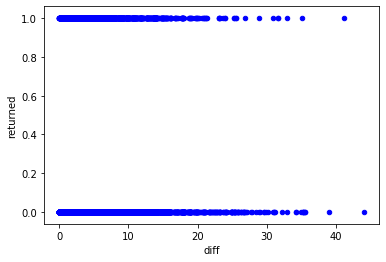

In [74]:
import matplotlib
import matplotlib.pyplot as plt

dc_data.plot(kind='scatter',x='diff', y='returned', color='blue')
plt.show()


In [75]:
range1 = dc_data[(dc_data['diff'] < 1)]['diff'].count()
print(range1)
range2 = dc_data[(dc_data['diff'] > 1)  & (dc_data['diff'] < 5)]['diff'].count()
print(range2)
range3 = dc_data[(dc_data['diff'] > 5)]['diff'].count()
print(range3)

range4 = dc_data2[(dc_data2['diff'] < 1)]['diff'].count()
print(range4)
range5 = dc_data2[(dc_data2['diff'] > 1)  & (dc_data2['diff'] < 5)]['diff'].count()
print(range5)
range6 = dc_data2[(dc_data2['diff'] > 5)]['diff'].count()
print(range6)

result1 = range1/range4
result2 = range2/range5
result3 = range3/range6

print("Result1: {} Result2: {} Result3: {}".format(result1, result2, result3))

59228
46173
9038
8436
5270
1139
Result1: 7.0208629682313894 Result2: 8.761480075901328 Result3: 7.935030728709394
